In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import mltools

In [2]:
class LSTMCSCModel(nn.Module):
    '''循环神经网络分类模型'''

    def __init__(self, *args, vocab_size, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.vocab_size = vocab_size  # 词汇表大小
        self.hidden_layer = nn.LSTM(self.vocab_size, hidden_size=512, batch_first=True, bidirectional=True)  # 定义隐藏层
        self.output_layer = nn.Linear(512 * 2, 2)  # 定义输出层

    def forward(self, x, state=None):
        '''前向传播'''
        x = F.one_hot(x, self.vocab_size)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = x.to(torch.float32)
        x, state = self.hidden_layer(x, state)  # x形状为(批量大小, 时间步数, 隐藏大小), state形状为(隐藏层数 * directions, 批量大小, 隐藏大小)
        x = x.mean(dim=1)  # 在时间步数维度取平均, x形状为(批量大小, 隐藏大小)
        x = self.output_layer(x)  # 它的输出形状是(批量大小, 输出大小)
        return x, state

In [3]:
class LSTMCSC(mltools.MachineLearning):
    '''RNN 文本分类学习'''

    @mltools.MachineLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train, _ = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val, _ = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.MachineLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test, _ = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.MachineLearning.predictor
    def predict(self):
        '''预测模型'''
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x = x[:10].to(self.device)
        y = y[:10].to(self.device)
        y_pred, _ = self.model(x)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        for content, pred, real in zip(x, y_pred, y):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {''.join(self.vocab[content.tolist()]).replace('<pad>', ' ')}')

In [4]:
train_iter, val_iter, test_iter, vocab = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')  # 加载词表，数据集
model = LSTMCSCModel(vocab_size=len(vocab))  # 定义训练模型
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1e-1)  # 设置优化器
legend = ['train loss', 'val loss', 'val acc']  # 设置图例
device = torch.device('cuda')  # 设置设备
ml = LSTMCSC(train_iter, val_iter, test_iter, vocab=vocab, model=model, loss=loss, optimizer=optimizer, legend=legend, device=device)

2025-05-24 15:44:16,343 - INFO: train loss 0.611, val loss 0.596, val acc 0.702, 38.7 sec/epoch on cuda


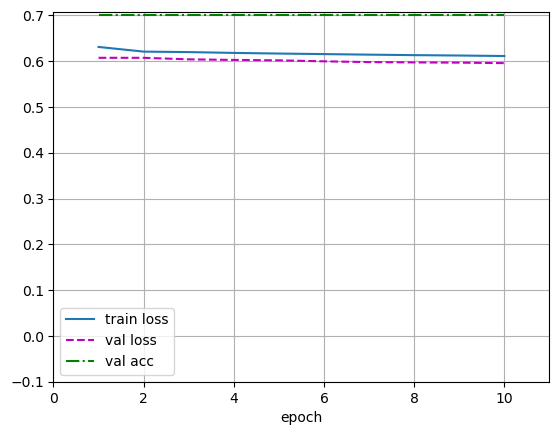

In [5]:
ml.train(num_epochs=10)  # 训练

In [6]:
ml.test()  # 测试

2025-05-24 15:44:19,659 - INFO: test acc 0.678


In [7]:
ml.predict()  # 预测

预测值 1, 真实值 1, 数据 我订的是430元的大床间，房间大小和设施都不错，卫生间里仅设淋浴房很实用，是我所欣赏的。早餐也还不错，中西都能<unk>顾。缺点：酒店餐厅晚8点就打<unk>，为了催还在就餐的客人就把灯<unk>了一半，暗暗的让人像在酒吧里吃饭，感觉这样的服务不够四星级；酒店没有停车场，停车就在大门口那一小块豆腐干似的地方，而且对住店客人也收费，不方便驾车族；酒店给了我们两个靠近电梯间的房间，一晚上电梯上下停靠的叮当声此起<unk><unk>，让人无法
预测值 1, 真实值 1, 数据 价格便宜,环境幽雅,就是餐厅跟不上,但服务态度及房间配置基本达                                                                                                                                                                         
预测值 1, 真实值 1, 数据 总体感觉不错.只是入住时收音机调节钮不能使用,打电话请工程部维修后才能听音乐,5颗星不应该这样.地灯也不亮,没有再计较.                                                                                                                                            
预测值 1, 真实值 1, 数据 真的是独栋别墅，我住的是每栋6间房，可惜没有了大床房。装修有点旧了，周边环境很好，适合休闲度假，这个价位超值了                                                                                                                                                 
预测值 1, 真实值 0, 数据 酒店自己宣传是5星级别，价格也不菲。所以我们就按照新五星酒店标准看看：1、位置在人和镇。总机服务员、到酒店网站上，没一个描述清晰的。后来才知道，就是人和镇。给司机说人和镇都知道。说金